In [1]:
import numpy as np
import pandas as pd
import copy
import datetime

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
## Load dataset

IMG_SHAPE = (96, 96, 3)
original_data = pd.read_csv("updated_train.csv")

Inspection of the dataset.

In [53]:
print("Dimensions of the dataset: ", original_data.shape)
print(original_data.loc[1,:])
column_names = list(original_data.columns)

Dimensions of the dataset:  (5563, 31)
left_eye_center_x                                                      64.3329
left_eye_center_y                                                      34.9701
right_eye_center_x                                                     29.9493
right_eye_center_y                                                     33.4487
left_eye_inner_corner_x                                                58.8562
left_eye_inner_corner_y                                                35.2743
left_eye_outer_corner_x                                                70.7227
left_eye_outer_corner_y                                                36.1872
right_eye_inner_corner_x                                               36.0347
right_eye_inner_corner_y                                               34.3615
right_eye_outer_corner_x                                               24.4725
right_eye_outer_corner_y                                               33.1444
left_eyebrow_

Let's find if there are missing values 

In [4]:
# Check what's the percentage of missing values
original_data.isnull().sum()/original_data.shape[0] *100

left_eye_center_x             0.179759
left_eye_center_y             0.179759
right_eye_center_x            0.233687
right_eye_center_y            0.233687
left_eye_inner_corner_x      58.313859
left_eye_inner_corner_y      58.313859
left_eye_outer_corner_x      58.403739
left_eye_outer_corner_y      58.403739
right_eye_inner_corner_x     58.385763
right_eye_inner_corner_y     58.385763
right_eye_outer_corner_x     58.403739
right_eye_outer_corner_y     58.403739
left_eyebrow_inner_end_x     58.331835
left_eyebrow_inner_end_y     58.331835
left_eyebrow_outer_end_x     59.194679
left_eyebrow_outer_end_y     59.194679
right_eyebrow_inner_end_x    58.331835
right_eyebrow_inner_end_y    58.331835
right_eyebrow_outer_end_x    58.996944
right_eyebrow_outer_end_y    58.996944
nose_tip_x                    0.000000
nose_tip_y                    0.000000
mouth_left_corner_x          58.367787
mouth_left_corner_y          58.367787
mouth_right_corner_x         58.349811
mouth_right_corner_y     

In [5]:
# Some of the images have missing values. Here we drop those having more missing values than `threshold`
threshold = 30
data = original_data.dropna(thresh = threshold)

# Number of features that needs to be estimated (x and y)
features_to_estimate = data.shape[1]-1
print(features_to_estimate)

30


## Prepare the dataset

In [6]:
from sklearn.model_selection import train_test_split

Y = data.iloc[:, :-1]
X_raw = data.iloc[:,-1]
dim_output = len(Y.columns.values)
original_batch_size = len(X_raw)
print(X_raw.shape, Y.shape)

(2182,) (2182, 30)


In [7]:
def convert_X(Xdf):
    """
    Function to convert each "Image" field in the csv file into a (96, 96, 1) image. 
    """
    batch_size = len(Xdf)
    X = np.zeros((batch_size, 96, 96, 3))

    for row in range(batch_size):
        for idx in range(3):
            X[row, :,:, idx] = np.array([float(i) for i in Xdf.iloc[row].split(" ")]).reshape(1,96,96)/255
    return X


X = convert_X(X_raw)
print(X.shape)

(2182, 96, 96, 3)


<IPython.core.display.Javascript object>


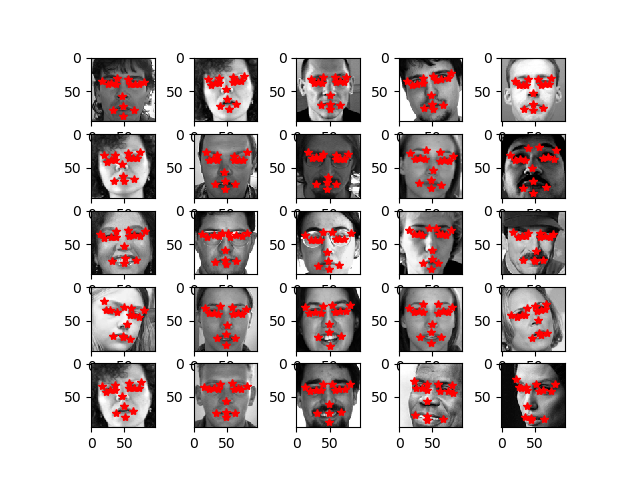

In [8]:
Y = np.array(Y)

plt.figure()
for i in range(25):
    idx = np.random.randint(0, high = X.shape[0])
    plt.subplot(5,5,1+i)
    plt.imshow(X[idx, :,:,0],cmap = "gray")
    plt.plot(Y[idx,::2],Y[idx,1::2], "*r")

## Perform dataset augmentation

Perform dataset augmentation by flipping up/down - left/right the images available

In [9]:
X0 = copy.deepcopy(X)
Y0 = np.array(Y)

# Flip up/down
Y1 = copy.deepcopy(Y0)
Y1[:,1::2] = IMG_SHAPE[1] - Y0[:,1::2]
Xaugmented = np.append(X0, X0[:,::-1,:,:], axis = 0)
Yaugmented = np.append(Y0, Y1, axis = 0)

# Flip left/right
Y1 = copy.deepcopy(Y0)
Y1[:,::2] = IMG_SHAPE[0] - Y0[:,::2]
Xaugmented = np.append(Xaugmented, X0[:,:,::-1,:], axis = 0)
Yaugmented = np.append(Yaugmented, Y1, axis = 0)

# Flip all
Y1 = copy.deepcopy(Y0)
Y1[:,::2] = IMG_SHAPE[0] - Y0[:,::2]
Y1[:,1::2] = IMG_SHAPE[0] - Y0[:,1::2]
Xaugmented = np.append(Xaugmented, X0[:,::-1,::-1,:], axis = 0)
Yaugmented = np.append(Yaugmented, Y1, axis = 0)

<IPython.core.display.Javascript object>


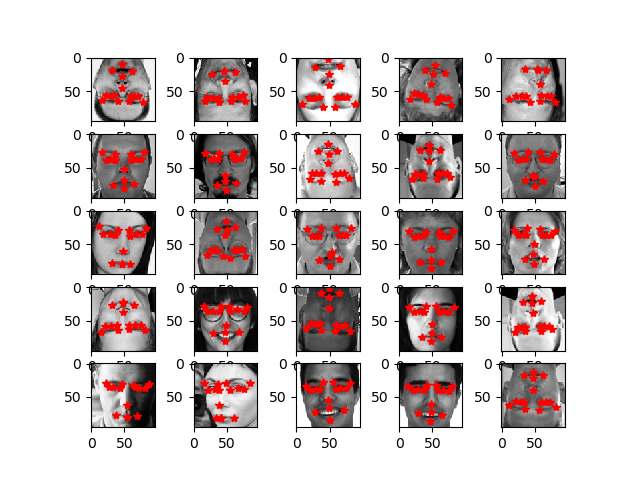

In [10]:
plt.figure()
for i in range(25):
    idx = np.random.randint(0, high = Xaugmented.shape[0])
    plt.subplot(5,5,1+i)
    plt.imshow(Xaugmented[idx, :,:,0],cmap = "gray")
    plt.plot(Yaugmented[idx,::2],Yaugmented[idx,1::2], "*r")

In [11]:
# Split train, validation and test set

XXtrain, Xtest, YYtrain, Ytest = train_test_split(X, Y, test_size = 0.05)
Xtrain, Xval, Ytrain, Yval = train_test_split(XXtrain, YYtrain, test_size = 0.2)

print("Train set: ", Xtrain.shape, Ytrain.shape)
print("Validation set: ", Xval.shape, Yval.shape)
print("Test set: ", Xtest.shape, Ytest.shape)

Train set:  (1657, 96, 96, 3) (1657, 30)
Validation set:  (415, 96, 96, 3) (415, 30)
Test set:  (110, 96, 96, 3) (110, 30)


## Apply transfer learning with pre-trained CNN
https://www.tensorflow.org/tutorials/images/transfer_learning?hl=it

In [12]:
import tensorflow as tf
keras = tf.keras
# Specify include_top=False not to include the last layer
base_model = keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                           include_top = False,
                                           weights = "imagenet")
lam = 0.4
lam = 0.7
fine_tune_at = 100
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable =  True
    layer.kernel_regularizer=tf.keras.regularizers.l2(lam)

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

We can see that the loaded CNN returns a (3,3,1280) tensor for each example. We need an output with shape (30,1). To this aim, let's follow the tutorial and add a [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) and a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer.

The `GlobalAveragePooling2D` layer is used to average each channel and reduce the final dimensions to (batch_size, 1, 1, 3840). 

The `Dense` layer is used to reduce the number of outputs from 1280 to 30. Since we need a coordinate between 0 and 96, we can use a linear activation.

In [14]:
global_average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()
intermediate_layer = tf.keras.layers.Dense(400, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(lam))
dense_layer = tf.keras.layers.Dense(features_to_estimate, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(lam))

Compile the model. We will use an Adam optimiser with decreasing learning rate and the MSE as loss function. Since the competition evaulates the results with the root MSE, we will define a new metric for that.

In [15]:
model = tf.keras.Sequential([base_model,
                             global_average_pooling_layer,
                             intermediate_layer,
                             dense_layer])
learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="mse",
              metrics= [tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 400)               512400    
_________________________________________________________________
dense_1 (Dense)              (None, 30)                12030     
Total params: 2,782,414
Trainable params: 2,748,302
Non-trainable params: 34,112
_________________________________________________________________


In [16]:
len(model.trainable_variables)

160

Let's fit the model

In [17]:
history = model.fit(x=np.array(Xtrain),
    y=np.array(Ytrain),    
    epochs=2000,
    batch_size=128,
    verbose=1,
    initial_epoch=0,
    validation_data=(np.array(Xval), np.array(Yval)),
    shuffle=True)

Train on 1657 samples, validate on 415 samples
Epoch 1/2000
1657/1657 [==============================] - 11s 7ms/sample - loss: 2905.5131 - root_mean_squared_error: 49.4688 - val_loss: 2689.4392 - val_root_mean_squared_error: 47.3058
Epoch 2/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 2426.7452 - root_mean_squared_error: 44.5009 - val_loss: 1331.6105 - val_root_mean_squared_error: 29.8490
Epoch 3/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 1690.6174 - root_mean_squared_error: 35.4099 - val_loss: 1396.9162 - val_root_mean_squared_error: 31.0488
Epoch 4/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 934.2537 - root_mean_squared_error: 22.4496 - val_loss: 4747.0550 - val_root_mean_squared_error: 65.7276
Epoch 5/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 582.6196 - root_mean_squared_error: 12.6571 - val_loss: 4616.2465 - val_root_mean_squared_error: 64.8115
Epoch 6/2000
1657/1657 [

1657/1657 [==============================] - 2s 1ms/sample - loss: 97.4431 - root_mean_squared_error: 2.9017 - val_loss: 206.3454 - val_root_mean_squared_error: 10.8991
Epoch 46/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 94.5685 - root_mean_squared_error: 2.8861 - val_loss: 192.1250 - val_root_mean_squared_error: 10.3621
Epoch 47/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 91.7714 - root_mean_squared_error: 2.8624 - val_loss: 196.3809 - val_root_mean_squared_error: 10.6863
Epoch 48/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 89.4895 - root_mean_squared_error: 2.8883 - val_loss: 197.8855 - val_root_mean_squared_error: 10.8657
Epoch 49/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 87.0275 - root_mean_squared_error: 2.8825 - val_loss: 191.6588 - val_root_mean_squared_error: 10.6884
Epoch 50/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 85.1715 - root_mea

1657/1657 [==============================] - 2s 1ms/sample - loss: 41.4762 - root_mean_squared_error: 2.6413 - val_loss: 64.3834 - val_root_mean_squared_error: 5.5048
Epoch 91/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 41.2281 - root_mean_squared_error: 2.6797 - val_loss: 66.1139 - val_root_mean_squared_error: 5.6763
Epoch 92/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 40.8062 - root_mean_squared_error: 2.6725 - val_loss: 66.6349 - val_root_mean_squared_error: 5.7494
Epoch 93/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 41.4627 - root_mean_squared_error: 2.8305 - val_loss: 67.4394 - val_root_mean_squared_error: 5.8440
Epoch 94/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 40.7789 - root_mean_squared_error: 2.7750 - val_loss: 65.8021 - val_root_mean_squared_error: 5.7363
Epoch 95/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 40.1650 - root_mean_squared_

1657/1657 [==============================] - 2s 1ms/sample - loss: 30.9681 - root_mean_squared_error: 2.4568 - val_loss: 44.2755 - val_root_mean_squared_error: 4.4114
Epoch 136/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 31.3096 - root_mean_squared_error: 2.5490 - val_loss: 44.4581 - val_root_mean_squared_error: 4.4509
Epoch 137/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 30.8133 - root_mean_squared_error: 2.4735 - val_loss: 45.9503 - val_root_mean_squared_error: 4.6208
Epoch 138/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 30.5355 - root_mean_squared_error: 2.4503 - val_loss: 44.6627 - val_root_mean_squared_error: 4.4911
Epoch 139/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 30.5856 - root_mean_squared_error: 2.4803 - val_loss: 43.1401 - val_root_mean_squared_error: 4.3244
Epoch 140/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 30.3233 - root_mean_squ

1657/1657 [==============================] - 2s 1ms/sample - loss: 27.0562 - root_mean_squared_error: 2.5300 - val_loss: 36.8414 - val_root_mean_squared_error: 4.0336
Epoch 181/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 26.7196 - root_mean_squared_error: 2.4741 - val_loss: 37.4494 - val_root_mean_squared_error: 4.1109
Epoch 182/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 26.8517 - root_mean_squared_error: 2.5215 - val_loss: 37.8701 - val_root_mean_squared_error: 4.1730
Epoch 183/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 27.1439 - root_mean_squared_error: 2.5749 - val_loss: 37.3650 - val_root_mean_squared_error: 4.1159
Epoch 184/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 27.3086 - root_mean_squared_error: 2.6335 - val_loss: 34.3853 - val_root_mean_squared_error: 3.7520
Epoch 185/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 26.5920 - root_mean_squ

1657/1657 [==============================] - 3s 2ms/sample - loss: 23.7864 - root_mean_squared_error: 2.4340 - val_loss: 31.6122 - val_root_mean_squared_error: 3.7068
Epoch 226/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 23.9406 - root_mean_squared_error: 2.4739 - val_loss: 28.8315 - val_root_mean_squared_error: 3.3375
Epoch 227/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 23.5305 - root_mean_squared_error: 2.4053 - val_loss: 30.0878 - val_root_mean_squared_error: 3.5277
Epoch 228/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 23.8071 - root_mean_squared_error: 2.4702 - val_loss: 28.6339 - val_root_mean_squared_error: 3.3215
Epoch 229/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 23.6154 - root_mean_squared_error: 2.4440 - val_loss: 29.4424 - val_root_mean_squared_error: 3.4313
Epoch 230/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 23.7002 - root_mean_squ

1657/1657 [==============================] - 3s 2ms/sample - loss: 22.0544 - root_mean_squared_error: 2.4396 - val_loss: 26.3873 - val_root_mean_squared_error: 3.2057
Epoch 271/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 22.1633 - root_mean_squared_error: 2.4695 - val_loss: 27.5823 - val_root_mean_squared_error: 3.3898
Epoch 272/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 22.4663 - root_mean_squared_error: 2.5321 - val_loss: 27.6014 - val_root_mean_squared_error: 3.4096
Epoch 273/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 22.4636 - root_mean_squared_error: 2.5407 - val_loss: 27.4560 - val_root_mean_squared_error: 3.3998
Epoch 274/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 22.2395 - root_mean_squared_error: 2.5111 - val_loss: 26.3655 - val_root_mean_squared_error: 3.2478
Epoch 275/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 22.2983 - root_mean_squ

1657/1657 [==============================] - 4s 2ms/sample - loss: 20.7700 - root_mean_squared_error: 2.4159 - val_loss: 24.9179 - val_root_mean_squared_error: 3.1836
Epoch 316/2000
1657/1657 [==============================] - 4s 2ms/sample - loss: 20.6965 - root_mean_squared_error: 2.4165 - val_loss: 24.2003 - val_root_mean_squared_error: 3.0763
Epoch 317/2000
1657/1657 [==============================] - 4s 2ms/sample - loss: 20.4231 - root_mean_squared_error: 2.3593 - val_loss: 25.6356 - val_root_mean_squared_error: 3.2879
Epoch 318/2000
1657/1657 [==============================] - 4s 2ms/sample - loss: 20.4642 - root_mean_squared_error: 2.3717 - val_loss: 28.1542 - val_root_mean_squared_error: 3.6331
Epoch 319/2000
1657/1657 [==============================] - 4s 2ms/sample - loss: 20.4997 - root_mean_squared_error: 2.3789 - val_loss: 26.7261 - val_root_mean_squared_error: 3.4434
Epoch 320/2000
1657/1657 [==============================] - 4s 2ms/sample - loss: 20.1482 - root_mean_squ

1657/1657 [==============================] - 3s 2ms/sample - loss: 19.6347 - root_mean_squared_error: 2.3373 - val_loss: 23.8916 - val_root_mean_squared_error: 3.1252
Epoch 361/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 19.4719 - root_mean_squared_error: 2.3120 - val_loss: 23.2301 - val_root_mean_squared_error: 3.0318
Epoch 362/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 19.7036 - root_mean_squared_error: 2.3628 - val_loss: 24.4841 - val_root_mean_squared_error: 3.2184
Epoch 363/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 19.8222 - root_mean_squared_error: 2.3876 - val_loss: 24.8152 - val_root_mean_squared_error: 3.2562
Epoch 364/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 19.5996 - root_mean_squared_error: 2.3434 - val_loss: 24.3457 - val_root_mean_squared_error: 3.1894
Epoch 365/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 19.7905 - root_mean_squ

1657/1657 [==============================] - 3s 2ms/sample - loss: 19.1747 - root_mean_squared_error: 2.3474 - val_loss: 23.2627 - val_root_mean_squared_error: 3.1080
Epoch 406/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 18.8889 - root_mean_squared_error: 2.2941 - val_loss: 23.3911 - val_root_mean_squared_error: 3.1257
Epoch 407/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 18.9836 - root_mean_squared_error: 2.3201 - val_loss: 22.0457 - val_root_mean_squared_error: 2.9147
Epoch 408/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 19.0634 - root_mean_squared_error: 2.3387 - val_loss: 23.2148 - val_root_mean_squared_error: 3.1030
Epoch 409/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 19.1622 - root_mean_squared_error: 2.3575 - val_loss: 25.6990 - val_root_mean_squared_error: 3.4731
Epoch 410/2000
1657/1657 [==============================] - 4s 2ms/sample - loss: 19.1194 - root_mean_squ

1657/1657 [==============================] - 3s 2ms/sample - loss: 18.6288 - root_mean_squared_error: 2.3104 - val_loss: 21.9454 - val_root_mean_squared_error: 2.9512
Epoch 451/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 18.5857 - root_mean_squared_error: 2.3065 - val_loss: 23.1767 - val_root_mean_squared_error: 3.1378
Epoch 452/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 18.5190 - root_mean_squared_error: 2.2923 - val_loss: 21.7997 - val_root_mean_squared_error: 2.9347
Epoch 453/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 18.5169 - root_mean_squared_error: 2.2988 - val_loss: 22.9525 - val_root_mean_squared_error: 3.1160
Epoch 454/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 18.4089 - root_mean_squared_error: 2.2767 - val_loss: 21.3632 - val_root_mean_squared_error: 2.8538
Epoch 455/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 18.5857 - root_mean_squ

1657/1657 [==============================] - 3s 2ms/sample - loss: 18.4177 - root_mean_squared_error: 2.3350 - val_loss: 20.6464 - val_root_mean_squared_error: 2.7712
Epoch 496/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 18.1792 - root_mean_squared_error: 2.2852 - val_loss: 21.6735 - val_root_mean_squared_error: 2.9456
Epoch 497/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 18.4284 - root_mean_squared_error: 2.3397 - val_loss: 22.3338 - val_root_mean_squared_error: 3.0485
Epoch 498/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 18.4503 - root_mean_squared_error: 2.3397 - val_loss: 21.0366 - val_root_mean_squared_error: 2.8502
Epoch 499/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 18.0708 - root_mean_squared_error: 2.2711 - val_loss: 21.6809 - val_root_mean_squared_error: 2.9577
Epoch 500/2000
1657/1657 [==============================] - 3s 2ms/sample - loss: 18.0813 - root_mean_squ

1657/1657 [==============================] - 2s 1ms/sample - loss: 17.7874 - root_mean_squared_error: 2.2597 - val_loss: 21.5080 - val_root_mean_squared_error: 2.9693
Epoch 541/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.8364 - root_mean_squared_error: 2.2689 - val_loss: 22.1458 - val_root_mean_squared_error: 3.0730
Epoch 542/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.8231 - root_mean_squared_error: 2.2761 - val_loss: 21.1224 - val_root_mean_squared_error: 2.9001
Epoch 543/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.7134 - root_mean_squared_error: 2.2432 - val_loss: 20.3572 - val_root_mean_squared_error: 2.7814
Epoch 544/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.6738 - root_mean_squared_error: 2.2400 - val_loss: 21.3147 - val_root_mean_squared_error: 2.9480
Epoch 545/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.6195 - root_mean_squ

1657/1657 [==============================] - 2s 1ms/sample - loss: 17.4332 - root_mean_squared_error: 2.2408 - val_loss: 20.6138 - val_root_mean_squared_error: 2.8670
Epoch 586/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.4126 - root_mean_squared_error: 2.2380 - val_loss: 20.6251 - val_root_mean_squared_error: 2.8726
Epoch 587/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.3719 - root_mean_squared_error: 2.2314 - val_loss: 21.6092 - val_root_mean_squared_error: 3.0290
Epoch 588/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.4914 - root_mean_squared_error: 2.2571 - val_loss: 22.0371 - val_root_mean_squared_error: 3.0971
Epoch 589/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.4196 - root_mean_squared_error: 2.2414 - val_loss: 21.0973 - val_root_mean_squared_error: 2.9566
Epoch 590/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.3340 - root_mean_squ

1657/1657 [==============================] - 2s 1ms/sample - loss: 17.1996 - root_mean_squared_error: 2.2510 - val_loss: 22.3992 - val_root_mean_squared_error: 3.1861
Epoch 631/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.5046 - root_mean_squared_error: 2.3114 - val_loss: 21.2485 - val_root_mean_squared_error: 3.0362
Epoch 632/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.3413 - root_mean_squared_error: 2.2790 - val_loss: 23.2960 - val_root_mean_squared_error: 3.3232
Epoch 633/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.1196 - root_mean_squared_error: 2.2319 - val_loss: 21.5635 - val_root_mean_squared_error: 3.0673
Epoch 634/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 16.9950 - root_mean_squared_error: 2.2073 - val_loss: 19.9909 - val_root_mean_squared_error: 2.8134
Epoch 635/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 17.2693 - root_mean_squ

1657/1657 [==============================] - 2s 1ms/sample - loss: 16.7421 - root_mean_squared_error: 2.2079 - val_loss: 21.9096 - val_root_mean_squared_error: 3.1813
Epoch 676/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 16.7369 - root_mean_squared_error: 2.2093 - val_loss: 23.4624 - val_root_mean_squared_error: 3.4042
Epoch 677/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 16.6737 - root_mean_squared_error: 2.2024 - val_loss: 23.8325 - val_root_mean_squared_error: 3.4558
Epoch 678/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 16.6895 - root_mean_squared_error: 2.2039 - val_loss: 22.7299 - val_root_mean_squared_error: 3.3039
Epoch 679/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 16.6941 - root_mean_squared_error: 2.2089 - val_loss: 23.8939 - val_root_mean_squared_error: 3.4729
Epoch 680/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 16.6338 - root_mean_squ

1657/1657 [==============================] - 2s 1ms/sample - loss: 16.3273 - root_mean_squared_error: 2.1903 - val_loss: 21.2756 - val_root_mean_squared_error: 3.1211
Epoch 721/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 16.3657 - root_mean_squared_error: 2.2029 - val_loss: 22.7426 - val_root_mean_squared_error: 3.3387
Epoch 722/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 16.3159 - root_mean_squared_error: 2.1857 - val_loss: 22.8792 - val_root_mean_squared_error: 3.3661
Epoch 723/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 16.2650 - root_mean_squared_error: 2.1815 - val_loss: 21.6427 - val_root_mean_squared_error: 3.1910
Epoch 724/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 16.1844 - root_mean_squared_error: 2.1640 - val_loss: 21.1399 - val_root_mean_squared_error: 3.1096
Epoch 725/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 16.0917 - root_mean_squ

1657/1657 [==============================] - 2s 1ms/sample - loss: 15.9465 - root_mean_squared_error: 2.1674 - val_loss: 21.9773 - val_root_mean_squared_error: 3.2713
Epoch 766/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.9033 - root_mean_squared_error: 2.1604 - val_loss: 22.3373 - val_root_mean_squared_error: 3.3230
Epoch 767/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.9388 - root_mean_squared_error: 2.1642 - val_loss: 21.0259 - val_root_mean_squared_error: 3.1311
Epoch 768/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.9328 - root_mean_squared_error: 2.1672 - val_loss: 20.2344 - val_root_mean_squared_error: 3.0123
Epoch 769/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 16.0487 - root_mean_squared_error: 2.1961 - val_loss: 21.1717 - val_root_mean_squared_error: 3.1606
Epoch 770/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.9760 - root_mean_squ

1657/1657 [==============================] - 2s 1ms/sample - loss: 15.5714 - root_mean_squared_error: 2.1365 - val_loss: 23.2037 - val_root_mean_squared_error: 3.5022
Epoch 811/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.6813 - root_mean_squared_error: 2.1614 - val_loss: 22.6906 - val_root_mean_squared_error: 3.4122
Epoch 812/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.6971 - root_mean_squared_error: 2.1691 - val_loss: 21.9980 - val_root_mean_squared_error: 3.3143
Epoch 813/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.5903 - root_mean_squared_error: 2.1442 - val_loss: 21.0595 - val_root_mean_squared_error: 3.1727
Epoch 814/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.6653 - root_mean_squared_error: 2.1608 - val_loss: 22.3513 - val_root_mean_squared_error: 3.3718
Epoch 815/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.5761 - root_mean_squ

1657/1657 [==============================] - 2s 1ms/sample - loss: 15.3156 - root_mean_squared_error: 2.1283 - val_loss: 18.0479 - val_root_mean_squared_error: 2.7114
Epoch 856/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.3190 - root_mean_squared_error: 2.1354 - val_loss: 19.5079 - val_root_mean_squared_error: 2.9635
Epoch 857/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.3272 - root_mean_squared_error: 2.1383 - val_loss: 22.5391 - val_root_mean_squared_error: 3.4162
Epoch 858/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.3696 - root_mean_squared_error: 2.1419 - val_loss: 21.8263 - val_root_mean_squared_error: 3.3181
Epoch 859/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.2606 - root_mean_squared_error: 2.1196 - val_loss: 21.8359 - val_root_mean_squared_error: 3.3285
Epoch 860/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.3395 - root_mean_squ

1657/1657 [==============================] - 2s 1ms/sample - loss: 15.1063 - root_mean_squared_error: 2.1314 - val_loss: 18.7539 - val_root_mean_squared_error: 2.8681
Epoch 901/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.0539 - root_mean_squared_error: 2.1245 - val_loss: 18.1503 - val_root_mean_squared_error: 2.7746
Epoch 902/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.0602 - root_mean_squared_error: 2.1273 - val_loss: 19.1566 - val_root_mean_squared_error: 2.9414
Epoch 903/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.0605 - root_mean_squared_error: 2.1297 - val_loss: 20.0258 - val_root_mean_squared_error: 3.0788
Epoch 904/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.1963 - root_mean_squared_error: 2.1603 - val_loss: 19.1584 - val_root_mean_squared_error: 2.9443
Epoch 905/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 15.0492 - root_mean_squ

1657/1657 [==============================] - 2s 1ms/sample - loss: 14.7560 - root_mean_squared_error: 2.1009 - val_loss: 18.7401 - val_root_mean_squared_error: 2.8948
Epoch 946/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.7134 - root_mean_squared_error: 2.0951 - val_loss: 18.7694 - val_root_mean_squared_error: 2.8982
Epoch 947/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.6313 - root_mean_squared_error: 2.0796 - val_loss: 17.4530 - val_root_mean_squared_error: 2.6743
Epoch 948/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.6305 - root_mean_squared_error: 2.0797 - val_loss: 18.7832 - val_root_mean_squared_error: 2.9047
Epoch 949/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.7661 - root_mean_squared_error: 2.1120 - val_loss: 19.0952 - val_root_mean_squared_error: 2.9480
Epoch 950/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.8909 - root_mean_squ

1657/1657 [==============================] - 2s 1ms/sample - loss: 14.5733 - root_mean_squared_error: 2.1093 - val_loss: 17.8106 - val_root_mean_squared_error: 2.7702
Epoch 991/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.4996 - root_mean_squared_error: 2.0897 - val_loss: 17.0128 - val_root_mean_squared_error: 2.6297
Epoch 992/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.4709 - root_mean_squared_error: 2.0850 - val_loss: 17.8199 - val_root_mean_squared_error: 2.7755
Epoch 993/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.5281 - root_mean_squared_error: 2.0914 - val_loss: 19.2947 - val_root_mean_squared_error: 3.0219
Epoch 994/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.5972 - root_mean_squared_error: 2.1089 - val_loss: 18.6040 - val_root_mean_squared_error: 2.9036
Epoch 995/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.4086 - root_mean_squ

Epoch 1035/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.3738 - root_mean_squared_error: 2.0976 - val_loss: 17.2463 - val_root_mean_squared_error: 2.6964
Epoch 1036/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.3268 - root_mean_squared_error: 2.0857 - val_loss: 18.1605 - val_root_mean_squared_error: 2.8590
Epoch 1037/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.2146 - root_mean_squared_error: 2.0565 - val_loss: 18.5396 - val_root_mean_squared_error: 2.9250
Epoch 1038/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.2636 - root_mean_squared_error: 2.0698 - val_loss: 17.3580 - val_root_mean_squared_error: 2.7225
Epoch 1039/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.3513 - root_mean_squared_error: 2.0969 - val_loss: 17.6235 - val_root_mean_squared_error: 2.7717
Epoch 1040/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14

Epoch 1080/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.1150 - root_mean_squared_error: 2.0768 - val_loss: 17.1046 - val_root_mean_squared_error: 2.7005
Epoch 1081/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.0776 - root_mean_squared_error: 2.0721 - val_loss: 16.8643 - val_root_mean_squared_error: 2.6626
Epoch 1082/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.0659 - root_mean_squared_error: 2.0690 - val_loss: 19.5310 - val_root_mean_squared_error: 3.1101
Epoch 1083/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.1329 - root_mean_squared_error: 2.0814 - val_loss: 20.0374 - val_root_mean_squared_error: 3.2008
Epoch 1084/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14.0020 - root_mean_squared_error: 2.0479 - val_loss: 18.1902 - val_root_mean_squared_error: 2.9037
Epoch 1085/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 14

Epoch 1125/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.7115 - root_mean_squared_error: 2.0206 - val_loss: 17.2365 - val_root_mean_squared_error: 2.7560
Epoch 1126/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.8181 - root_mean_squared_error: 2.0490 - val_loss: 20.2068 - val_root_mean_squared_error: 3.2366
Epoch 1127/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.9812 - root_mean_squared_error: 2.0883 - val_loss: 18.0387 - val_root_mean_squared_error: 2.8923
Epoch 1128/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.9588 - root_mean_squared_error: 2.0802 - val_loss: 16.0323 - val_root_mean_squared_error: 2.5410
Epoch 1129/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.8913 - root_mean_squared_error: 2.0685 - val_loss: 16.2601 - val_root_mean_squared_error: 2.5878
Epoch 1130/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13

Epoch 1170/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.5628 - root_mean_squared_error: 2.0238 - val_loss: 17.0188 - val_root_mean_squared_error: 2.7465
Epoch 1171/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.6139 - root_mean_squared_error: 2.0378 - val_loss: 17.3699 - val_root_mean_squared_error: 2.8058
Epoch 1172/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.7535 - root_mean_squared_error: 2.0674 - val_loss: 17.1024 - val_root_mean_squared_error: 2.7604
Epoch 1173/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.6211 - root_mean_squared_error: 2.0387 - val_loss: 16.0222 - val_root_mean_squared_error: 2.5641
Epoch 1174/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.5962 - root_mean_squared_error: 2.0341 - val_loss: 18.1716 - val_root_mean_squared_error: 2.9454
Epoch 1175/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13

Epoch 1215/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.4867 - root_mean_squared_error: 2.0402 - val_loss: 16.1963 - val_root_mean_squared_error: 2.6170
Epoch 1216/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.3747 - root_mean_squared_error: 2.0132 - val_loss: 16.4371 - val_root_mean_squared_error: 2.6636
Epoch 1217/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.3302 - root_mean_squared_error: 2.0006 - val_loss: 15.7621 - val_root_mean_squared_error: 2.5445
Epoch 1218/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.4132 - root_mean_squared_error: 2.0237 - val_loss: 15.0879 - val_root_mean_squared_error: 2.4153
Epoch 1219/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.3788 - root_mean_squared_error: 2.0165 - val_loss: 14.8509 - val_root_mean_squared_error: 2.3692
Epoch 1220/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13

Epoch 1260/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.2076 - root_mean_squared_error: 2.0089 - val_loss: 15.6125 - val_root_mean_squared_error: 2.5380
Epoch 1261/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.1926 - root_mean_squared_error: 2.0079 - val_loss: 14.9720 - val_root_mean_squared_error: 2.4114
Epoch 1262/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.1143 - root_mean_squared_error: 1.9856 - val_loss: 14.8987 - val_root_mean_squared_error: 2.3916
Epoch 1263/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.0904 - root_mean_squared_error: 1.9809 - val_loss: 14.9549 - val_root_mean_squared_error: 2.4091
Epoch 1264/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.2186 - root_mean_squared_error: 2.0154 - val_loss: 15.0034 - val_root_mean_squared_error: 2.4203
Epoch 1265/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13

Epoch 1305/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.2176 - root_mean_squared_error: 2.0366 - val_loss: 15.7466 - val_root_mean_squared_error: 2.5777
Epoch 1306/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.2615 - root_mean_squared_error: 2.0503 - val_loss: 16.6364 - val_root_mean_squared_error: 2.7435
Epoch 1307/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.1066 - root_mean_squared_error: 2.0158 - val_loss: 14.3097 - val_root_mean_squared_error: 2.3144
Epoch 1308/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.0734 - root_mean_squared_error: 2.0124 - val_loss: 16.1030 - val_root_mean_squared_error: 2.6629
Epoch 1309/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.0572 - root_mean_squared_error: 2.0106 - val_loss: 18.2658 - val_root_mean_squared_error: 3.0334
Epoch 1310/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13

Epoch 1350/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.1732 - root_mean_squared_error: 2.0636 - val_loss: 13.9411 - val_root_mean_squared_error: 2.2577
Epoch 1351/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.0429 - root_mean_squared_error: 2.0344 - val_loss: 14.6292 - val_root_mean_squared_error: 2.3898
Epoch 1352/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.9898 - root_mean_squared_error: 2.0190 - val_loss: 14.2403 - val_root_mean_squared_error: 2.3100
Epoch 1353/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 13.0842 - root_mean_squared_error: 2.0385 - val_loss: 17.1588 - val_root_mean_squared_error: 2.8597
Epoch 1354/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.9784 - root_mean_squared_error: 2.0128 - val_loss: 15.0565 - val_root_mean_squared_error: 2.4763
Epoch 1355/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12

Epoch 1395/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.7377 - root_mean_squared_error: 1.9897 - val_loss: 14.5067 - val_root_mean_squared_error: 2.3935
Epoch 1396/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.6425 - root_mean_squared_error: 1.9704 - val_loss: 13.9246 - val_root_mean_squared_error: 2.2771
Epoch 1397/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.6201 - root_mean_squared_error: 1.9637 - val_loss: 13.9272 - val_root_mean_squared_error: 2.2713
Epoch 1398/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.6817 - root_mean_squared_error: 1.9762 - val_loss: 13.4750 - val_root_mean_squared_error: 2.1870
Epoch 1399/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.7558 - root_mean_squared_error: 1.9987 - val_loss: 14.3064 - val_root_mean_squared_error: 2.3464
Epoch 1400/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12

Epoch 1440/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.5435 - root_mean_squared_error: 1.9665 - val_loss: 15.2755 - val_root_mean_squared_error: 2.5662
Epoch 1441/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.5235 - root_mean_squared_error: 1.9575 - val_loss: 15.6476 - val_root_mean_squared_error: 2.6329
Epoch 1442/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.5677 - root_mean_squared_error: 1.9702 - val_loss: 14.6675 - val_root_mean_squared_error: 2.4428
Epoch 1443/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.5080 - root_mean_squared_error: 1.9597 - val_loss: 14.6616 - val_root_mean_squared_error: 2.4469
Epoch 1444/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.5570 - root_mean_squared_error: 1.9762 - val_loss: 14.0653 - val_root_mean_squared_error: 2.3227
Epoch 1445/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12

Epoch 1485/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.4133 - root_mean_squared_error: 1.9579 - val_loss: 14.0797 - val_root_mean_squared_error: 2.3640
Epoch 1486/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.5799 - root_mean_squared_error: 2.0053 - val_loss: 13.7431 - val_root_mean_squared_error: 2.2954
Epoch 1487/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.4200 - root_mean_squared_error: 1.9683 - val_loss: 13.9540 - val_root_mean_squared_error: 2.3314
Epoch 1488/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.3497 - root_mean_squared_error: 1.9543 - val_loss: 14.9338 - val_root_mean_squared_error: 2.5246
Epoch 1489/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.4434 - root_mean_squared_error: 1.9778 - val_loss: 14.0492 - val_root_mean_squared_error: 2.3465
Epoch 1490/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12

Epoch 1530/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.2323 - root_mean_squared_error: 1.9449 - val_loss: 13.2345 - val_root_mean_squared_error: 2.1941
Epoch 1531/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.3671 - root_mean_squared_error: 1.9778 - val_loss: 13.2789 - val_root_mean_squared_error: 2.2144
Epoch 1532/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.2735 - root_mean_squared_error: 1.9590 - val_loss: 13.7810 - val_root_mean_squared_error: 2.3102
Epoch 1533/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.2307 - root_mean_squared_error: 1.9476 - val_loss: 13.7254 - val_root_mean_squared_error: 2.2984
Epoch 1534/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.2220 - root_mean_squared_error: 1.9485 - val_loss: 12.9822 - val_root_mean_squared_error: 2.1466
Epoch 1535/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12

Epoch 1575/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.1169 - root_mean_squared_error: 1.9448 - val_loss: 13.5366 - val_root_mean_squared_error: 2.2908
Epoch 1576/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.1254 - root_mean_squared_error: 1.9452 - val_loss: 13.2057 - val_root_mean_squared_error: 2.2196
Epoch 1577/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.2141 - root_mean_squared_error: 1.9694 - val_loss: 13.3797 - val_root_mean_squared_error: 2.2446
Epoch 1578/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.1557 - root_mean_squared_error: 1.9550 - val_loss: 13.2619 - val_root_mean_squared_error: 2.2243
Epoch 1579/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.0675 - root_mean_squared_error: 1.9383 - val_loss: 13.5998 - val_root_mean_squared_error: 2.2924
Epoch 1580/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12

Epoch 1620/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.0044 - root_mean_squared_error: 1.9429 - val_loss: 13.3636 - val_root_mean_squared_error: 2.2672
Epoch 1621/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.9995 - root_mean_squared_error: 1.9444 - val_loss: 13.1018 - val_root_mean_squared_error: 2.2127
Epoch 1622/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 12.0301 - root_mean_squared_error: 1.9523 - val_loss: 13.3512 - val_root_mean_squared_error: 2.2611
Epoch 1623/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.9188 - root_mean_squared_error: 1.9274 - val_loss: 13.3565 - val_root_mean_squared_error: 2.2683
Epoch 1624/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.9809 - root_mean_squared_error: 1.9445 - val_loss: 13.4922 - val_root_mean_squared_error: 2.2954
Epoch 1625/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11

Epoch 1665/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.9441 - root_mean_squared_error: 1.9542 - val_loss: 12.7784 - val_root_mean_squared_error: 2.1602
Epoch 1666/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.8621 - root_mean_squared_error: 1.9351 - val_loss: 13.2460 - val_root_mean_squared_error: 2.2605
Epoch 1667/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.8927 - root_mean_squared_error: 1.9454 - val_loss: 12.8622 - val_root_mean_squared_error: 2.1829
Epoch 1668/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.8705 - root_mean_squared_error: 1.9395 - val_loss: 12.9712 - val_root_mean_squared_error: 2.2064
Epoch 1669/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.8619 - root_mean_squared_error: 1.9363 - val_loss: 12.5760 - val_root_mean_squared_error: 2.1224
Epoch 1670/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11

Epoch 1710/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.8304 - root_mean_squared_error: 1.9546 - val_loss: 13.4312 - val_root_mean_squared_error: 2.3190
Epoch 1711/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.9193 - root_mean_squared_error: 1.9753 - val_loss: 14.1592 - val_root_mean_squared_error: 2.4651
Epoch 1712/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.8722 - root_mean_squared_error: 1.9641 - val_loss: 13.7409 - val_root_mean_squared_error: 2.3821
Epoch 1713/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.7737 - root_mean_squared_error: 1.9399 - val_loss: 13.4358 - val_root_mean_squared_error: 2.3235
Epoch 1714/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.7949 - root_mean_squared_error: 1.9475 - val_loss: 14.6336 - val_root_mean_squared_error: 2.5580
Epoch 1715/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11

Epoch 1755/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.6134 - root_mean_squared_error: 1.9222 - val_loss: 12.3593 - val_root_mean_squared_error: 2.1071
Epoch 1756/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.5497 - root_mean_squared_error: 1.9072 - val_loss: 12.2963 - val_root_mean_squared_error: 2.0956
Epoch 1757/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.5750 - root_mean_squared_error: 1.9176 - val_loss: 12.1940 - val_root_mean_squared_error: 2.0742
Epoch 1758/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.5654 - root_mean_squared_error: 1.9139 - val_loss: 12.3622 - val_root_mean_squared_error: 2.1116
Epoch 1759/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.5651 - root_mean_squared_error: 1.9124 - val_loss: 12.1294 - val_root_mean_squared_error: 2.0630
Epoch 1760/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11

Epoch 1800/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.5481 - root_mean_squared_error: 1.9303 - val_loss: 12.2378 - val_root_mean_squared_error: 2.0934
Epoch 1801/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.4399 - root_mean_squared_error: 1.9029 - val_loss: 12.1514 - val_root_mean_squared_error: 2.0848
Epoch 1802/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.4574 - root_mean_squared_error: 1.9104 - val_loss: 12.2688 - val_root_mean_squared_error: 2.1073
Epoch 1803/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.4905 - root_mean_squared_error: 1.9175 - val_loss: 12.2390 - val_root_mean_squared_error: 2.1198
Epoch 1804/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.5717 - root_mean_squared_error: 1.9397 - val_loss: 12.2685 - val_root_mean_squared_error: 2.1247
Epoch 1805/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11

Epoch 1845/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.5299 - root_mean_squared_error: 1.9499 - val_loss: 13.4747 - val_root_mean_squared_error: 2.3808
Epoch 1846/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.5022 - root_mean_squared_error: 1.9445 - val_loss: 12.5437 - val_root_mean_squared_error: 2.1897
Epoch 1847/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.4640 - root_mean_squared_error: 1.9355 - val_loss: 12.1439 - val_root_mean_squared_error: 2.1055
Epoch 1848/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.4191 - root_mean_squared_error: 1.9223 - val_loss: 12.2082 - val_root_mean_squared_error: 2.1326
Epoch 1849/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.4446 - root_mean_squared_error: 1.9328 - val_loss: 12.0530 - val_root_mean_squared_error: 2.0851
Epoch 1850/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11

Epoch 1890/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.3928 - root_mean_squared_error: 1.9355 - val_loss: 12.8480 - val_root_mean_squared_error: 2.2687
Epoch 1891/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.3108 - root_mean_squared_error: 1.9155 - val_loss: 12.3598 - val_root_mean_squared_error: 2.1659
Epoch 1892/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.2553 - root_mean_squared_error: 1.8983 - val_loss: 12.0222 - val_root_mean_squared_error: 2.0913
Epoch 1893/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.2911 - root_mean_squared_error: 1.9090 - val_loss: 12.2122 - val_root_mean_squared_error: 2.1310
Epoch 1894/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.4839 - root_mean_squared_error: 1.9595 - val_loss: 12.0964 - val_root_mean_squared_error: 2.1093
Epoch 1895/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11

Epoch 1935/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.1938 - root_mean_squared_error: 1.9069 - val_loss: 12.3834 - val_root_mean_squared_error: 2.1907
Epoch 1936/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.1268 - root_mean_squared_error: 1.8891 - val_loss: 11.8660 - val_root_mean_squared_error: 2.0803
Epoch 1937/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.1304 - root_mean_squared_error: 1.8920 - val_loss: 11.9658 - val_root_mean_squared_error: 2.0981
Epoch 1938/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.0950 - root_mean_squared_error: 1.8822 - val_loss: 12.1438 - val_root_mean_squared_error: 2.1339
Epoch 1939/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.1554 - root_mean_squared_error: 1.8968 - val_loss: 11.6985 - val_root_mean_squared_error: 2.0454
Epoch 1940/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11

Epoch 1980/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.2515 - root_mean_squared_error: 1.9484 - val_loss: 11.8002 - val_root_mean_squared_error: 2.0970
Epoch 1981/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.3178 - root_mean_squared_error: 1.9650 - val_loss: 11.8134 - val_root_mean_squared_error: 2.0912
Epoch 1982/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.4999 - root_mean_squared_error: 2.0078 - val_loss: 13.5485 - val_root_mean_squared_error: 2.4478
Epoch 1983/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.2869 - root_mean_squared_error: 1.9519 - val_loss: 12.6509 - val_root_mean_squared_error: 2.2671
Epoch 1984/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11.1300 - root_mean_squared_error: 1.9136 - val_loss: 13.1497 - val_root_mean_squared_error: 2.3716
Epoch 1985/2000
1657/1657 [==============================] - 2s 1ms/sample - loss: 11

<IPython.core.display.Javascript object>


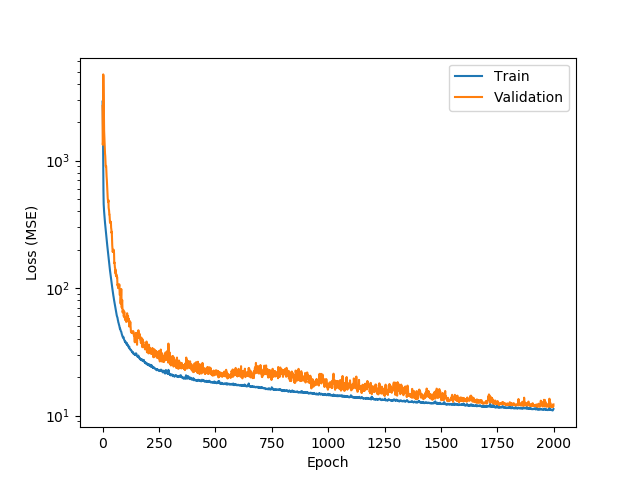

<IPython.core.display.Javascript object>


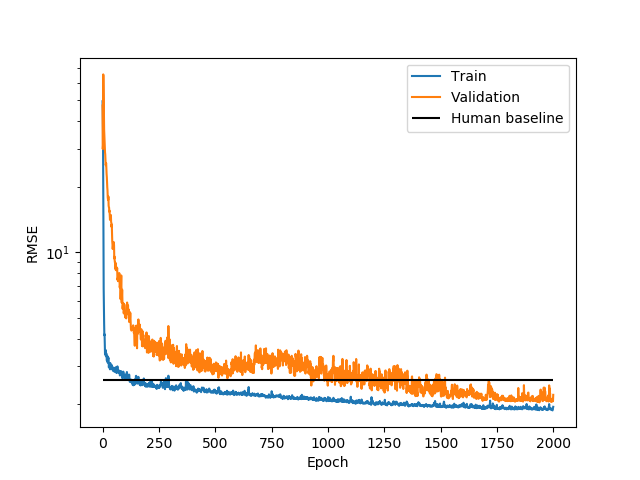

In [31]:
loss = history.history["loss"]
loss_val = history.history["val_loss"]
plt.figure()
plt.semilogy(loss, label = "Train")
plt.semilogy(loss_val, label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
# plt.plot(rmse, label = "Train")
# plt.plot(rmse_val, label = "Validation")
plt.legend()


rmse = history.history["root_mean_squared_error"]
rmse_val = history.history["val_root_mean_squared_error"]
plt.figure()
plt.semilogy(rmse, label = "Train")
plt.semilogy(rmse_val, label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.hlines(2.6, 0, 2000, label = "Human baseline", zorder = 3)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


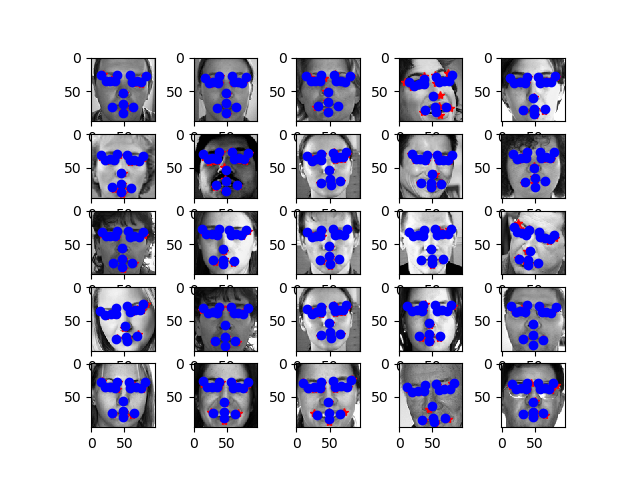

In [19]:
plt.figure()
XXX = np.array(Xtrain)
YYY = np.array(Ytrain)
prediction = model.predict(XXX)
for i in range(25):
    idx =np.random.randint(low = 0, high = Xtrain.shape[0]) 
    plt.subplot(5,5,i+1)
    plt.imshow(XXX[idx,:,:,0], cmap = "gray")
    plt.plot(YYY[idx,::2], YYY[idx, 1::2], "*r")
    plt.plot(prediction[idx,::2], prediction[idx,1::2], "ob")

<IPython.core.display.Javascript object>


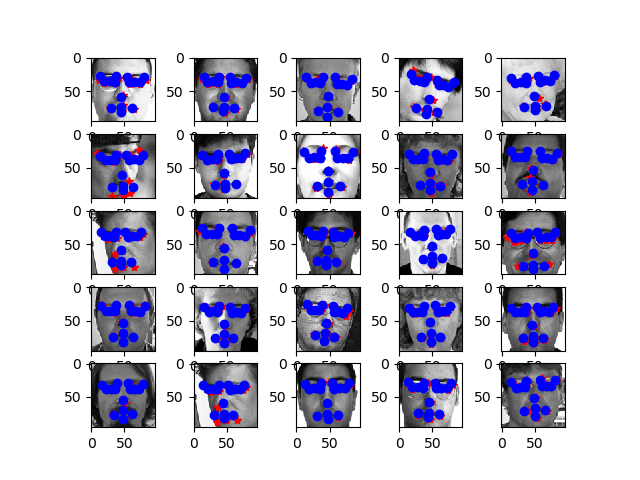

In [20]:
plt.figure()
XXX = np.array(Xval)
YYY = np.array(Yval)
prediction = model.predict(XXX)
for i in range(25):
    idx =np.random.randint(low = 0, high = XXX.shape[0]) 
    plt.subplot(5,5,i+1)
    plt.imshow(XXX[idx,:,:,0], cmap = "gray")
    plt.plot(YYY[idx,::2], YYY[idx, 1::2], "*r")
    plt.plot(prediction[idx,::2], prediction[idx,1::2], "ob")

In [21]:
model.save("mymodel_4.h5")

## Test set

In [36]:
test_performance = model.evaluate(x = Xtest,
                                  y = Ytest,
                                  verbose=0)
print("Performance on the test set: ", test_performance[1])
print("Human baseline: ", 2.6)

Performance on the test set:  2.0583458
Human baseline:  2.6


## Prediction for Kaggle

In [40]:
lut = pd.read_csv("IdLookupTable.csv")
test_database = pd.read_csv("test.csv")

In `test_database` there are the images, while in `lut` there is the list of features to be identified. 

In [47]:
Xsubmission = convert_X(test_database.iloc[:,-1])

In [48]:
Ysubmission = model.predict(Xsubmission)

In [70]:
print(Ysubmission)
print(Ysubmission.shape)

[[64.54679  34.971817 27.128574 ... 67.67268  45.978275 82.23626 ]
 [65.80216  35.553085 27.819332 ... 72.63708  48.468372 83.65158 ]
 [65.495636 37.086494 30.065262 ... 69.237526 48.87207  82.1064  ]
 ...
 [66.444695 40.452652 33.17291  ... 73.21296  45.753517 80.47429 ]
 [60.843426 36.318817 29.971828 ... 69.599236 45.700237 74.93556 ]
 [65.41745  39.31945  30.566332 ... 76.76261  46.201416 83.36498 ]]
(1783, 30)


<IPython.core.display.Javascript object>


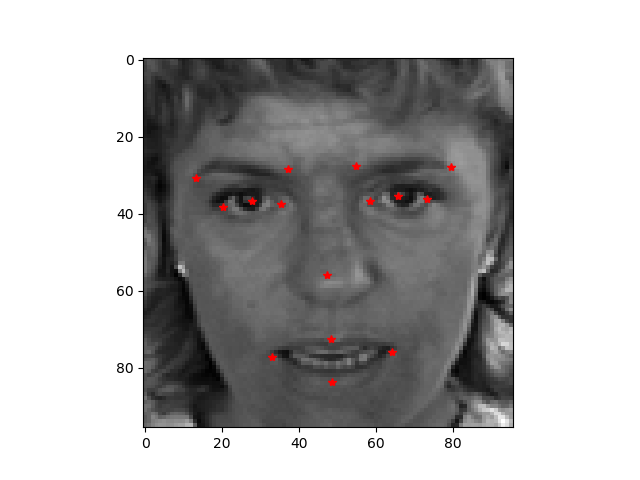

In [50]:
idx = 1
plt.figure()
plt.imshow(Xsubmission[idx,:,:,0], cmap = "gray")
plt.plot(Ysubmission[idx,::2], Ysubmission[idx, 1::2], "*r")

In [77]:
results = []
for i in range(len(lut)):
    image_idx = lut.ImageId[i]
    idx_feature_to_retrieve = column_names.index(lut.FeatureName[i])
    results.append(Ysubmission[image_idx-1, idx_feature_to_retrieve])
lut.Location = results

In [78]:
lut

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,64.546791
1,2,1,left_eye_center_y,34.971817
2,3,1,right_eye_center_x,27.128574
3,4,1,right_eye_center_y,34.888443
4,5,1,left_eye_inner_corner_x,57.981129
5,6,1,left_eye_inner_corner_y,35.655716
6,7,1,left_eye_outer_corner_x,71.176476
7,8,1,left_eye_outer_corner_y,35.990204
8,9,1,right_eye_inner_corner_x,33.793385
9,10,1,right_eye_inner_corner_y,35.505070


In [83]:
lut.to_csv("my_submission.csv", index=False, columns=("RowId","Location"))